# Dependencias

In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from sklearn.preprocessing import MinMaxScaler

from scikitplot.metrics import plot_roc

from varclushi import VarClusHi

import seaborn as sns
import cufflinks as cf
import matplotlib.pyplot as plt

cf.go_offline()
pd.set_option('display.max_columns',None)

# Lectura de datos

In [2]:
ruta = '/home/oscarjarillo/Documentos/Análisis Multivariado/Perceptron/Fraud.csv'
df = pd.read_csv(ruta)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
df.shape

(6362620, 11)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


# Previo análisis exploratorio

## Balanceo de muestra

In [5]:
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [6]:
X = pd.concat([d.sample(8213) for _,d in df.groupby('isFraud')],ignore_index=True)

In [8]:
X['isFraud'].value_counts()

0    8213
1    8213
Name: isFraud, dtype: int64

In [9]:
for v in X.columns:
    if X[v].dtype=='object':
        for a,b in zip(list(X[v].unique()),range(1,len(list(X[v].unique()))+1)):
            X.loc[X[v]==a,v]=b
        X[v] = pd.to_numeric(X[v])

In [10]:
X.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,402,1,169105.36,1,0.00,0.00,1,12668292.97,12837398.33,0,0
1,236,2,446749.76,2,0.00,0.00,2,1461107.09,1907856.85,0,0
2,374,3,201027.86,3,22276592.04,22477619.91,3,402829.49,201801.63,0,0
3,155,4,3758.98,4,4525.00,766.02,4,0.00,0.00,0,0
4,207,1,67508.36,5,54461.00,0.00,5,15020.45,82528.80,0,0


# Definición de variables

In [11]:
X.insert(0,'id',X.index+1)

In [13]:
um = ['id']
vart = ['isFraud']
varc = [v for v in X.columns if v not in um and v not in vart and v!='isFlaggedFraud']

# Análisis exploratorio

## Valores nulos

In [14]:
nulos = 1-X.describe().T[['count']]/len(X)
nulos

,count
id,0.0
step,0.0
type,0.0
amount,0.0
nameOrig,0.0
oldbalanceOrg,0.0
newbalanceOrig,0.0
nameDest,0.0
oldbalanceDest,0.0
newbalanceDest,0.0


## Varianza nula

In [15]:
vt =VarianceThreshold()
vt.fit(X[varc])

VarianceThreshold()

In [16]:
fuera = [a for a,b in zip(varc,vt.get_support())if not b]
fuera

[]

## Multicolinealidad

In [18]:
vc = VarClusHi(df=X[varc],feat_list=varc).varclus().rsquare.sort_values(by=['Cluster','RS_Ratio']).reset_index(drop=True)
display(vc)
best = sorted(vc.groupby('Cluster').first()['Variable'])
best

,Cluster,Variable,RS_Own,RS_NC,RS_Ratio
0,0,nameOrig,0.904083,0.010830,0.096968
1,0,nameDest,0.902835,0.010821,0.098228
2,0,type,0.372012,0.018208,0.639635
3,0,step,0.217479,0.006063,0.787294
4,1,oldbalanceOrg,0.994712,0.010103,0.005342
5,1,newbalanceOrig,0.666907,0.017430,0.339002
6,1,amount,0.447611,0.101723,0.614942
7,2,oldbalanceDest,0.968356,0.000732,0.031667
8,2,newbalanceDest,0.968356,0.015331,0.032137


['nameOrig', 'oldbalanceDest', 'oldbalanceOrg']

## Selección de variables con mejor poder predictivo

In [20]:
sk = SelectKBest(k=len(varc))
sk.fit(X[varc],X[vart[0]])

SelectKBest(k=9)

In [21]:
pd.DataFrame(zip(varc,sk.scores_),columns=['var','score']).set_index('var').sort_values(by='score',
                                                        ascending=False).iplot(kind='bar',color='orange')

In [22]:
sk = SelectKBest(k=3)
sk.fit(X[varc],X[vart[0]])

SelectKBest(k=3)

In [23]:
best1 = [a for a,b in zip(varc,sk.get_support())if b]
best1

['type', 'nameOrig', 'nameDest']

## Valores extremos

### Best

array([[<AxesSubplot:title={'center':'nameOrig'}>,
        <AxesSubplot:title={'center':'oldbalanceDest'}>],
       [<AxesSubplot:title={'center':'oldbalanceOrg'}>, <AxesSubplot:>]],
      dtype=object)

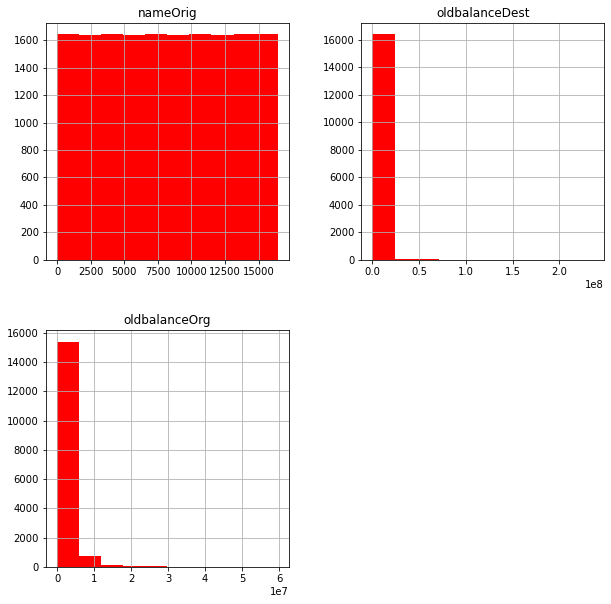

In [24]:
X[best].hist(figsize=(10,10),color='red')

In [25]:
for v,li,ls in X[best].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values:
    X[f'ex_{v}'] = ((X[v]<li)|(X[v]>ls)).astype(int)
X['ex_'] = X.filter(like='ex_').max(axis=1)
X['ex_'].value_counts(1)

0    0.960124
1    0.039876
Name: ex_, dtype: float64

In [26]:
Xbest = X.copy()

In [27]:
Xbest[um+vart] = X[um+vart]

In [28]:
Xbest = Xbest.loc[Xbest['ex_']==0].drop(X.filter(like='ex_').columns,axis=1).reset_index(drop=True)

array([[<AxesSubplot:title={'center':'nameOrig'}>,
        <AxesSubplot:title={'center':'oldbalanceDest'}>],
       [<AxesSubplot:title={'center':'oldbalanceOrg'}>, <AxesSubplot:>]],
      dtype=object)

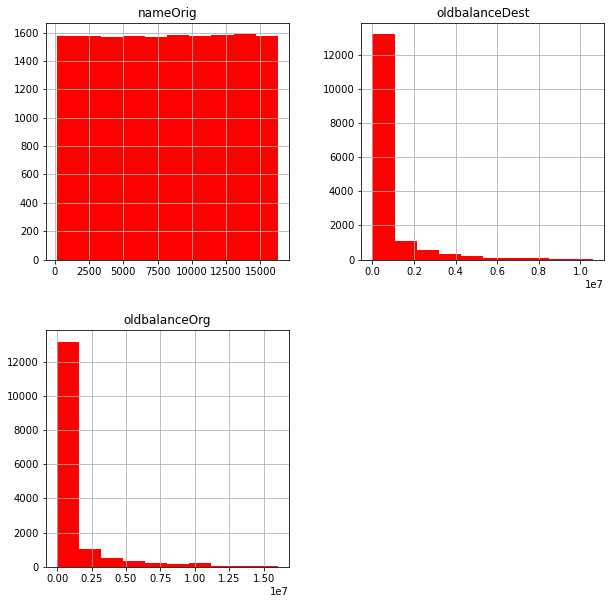

In [29]:
Xbest[best].hist(figsize=(10,10),color='red')

### Best1

array([[<AxesSubplot:title={'center':'type'}>,
        <AxesSubplot:title={'center':'nameOrig'}>],
       [<AxesSubplot:title={'center':'nameDest'}>, <AxesSubplot:>]],
      dtype=object)

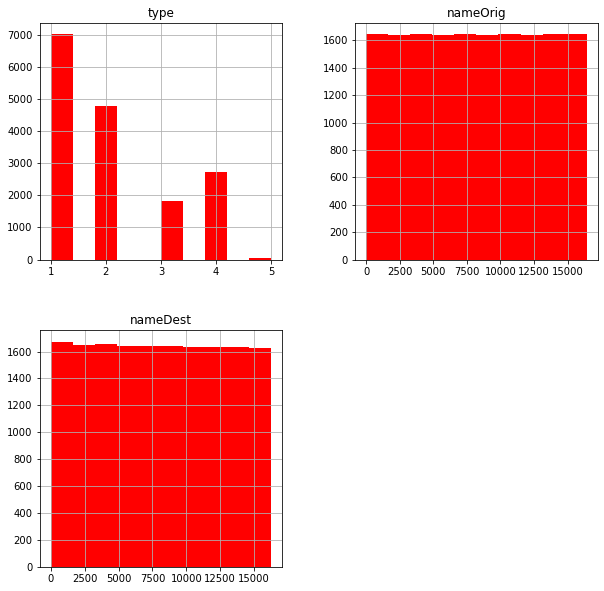

In [30]:
X[best1].hist(figsize=(10,10),color='red')

In [31]:
for v,li,ls in X[best1].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values:
    X[f'ex_{v}'] = ((X[v]<li)|(X[v]>ls)).astype(int)
X['ex_'] = X.filter(like='ex_').max(axis=1)
X['ex_'].value_counts(1)

0    0.956654
1    0.043346
Name: ex_, dtype: float64

In [32]:
Xbest1 = X.copy()

In [33]:
Xbest1[um+vart] = X[um+vart]

In [34]:
Xbest1 = Xbest1.loc[Xbest1['ex_']==0].drop(X.filter(like='ex_').columns,axis=1).reset_index(drop=True)

array([[<AxesSubplot:title={'center':'type'}>,
        <AxesSubplot:title={'center':'nameOrig'}>],
       [<AxesSubplot:title={'center':'nameDest'}>, <AxesSubplot:>]],
      dtype=object)

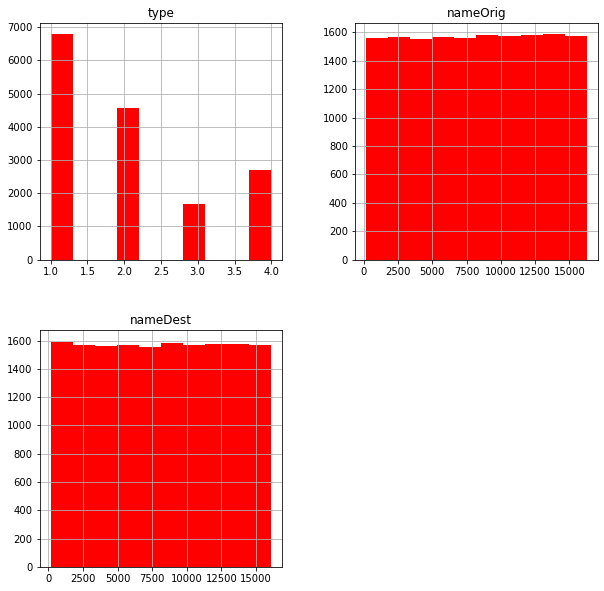

In [35]:
Xbest1[best1].hist(figsize=(10,10),color='red')

# Cambio de espacio $\mathcal{X}_{[0,1]}$

In [41]:
sc1 = MinMaxScaler()
sc2 = MinMaxScaler()
sc1.fit(Xbest[best])
sc2.fit(Xbest1[best1])

MinMaxScaler()

In [43]:
X01 = pd.DataFrame(sc1.transform(Xbest[best]),columns=best)
X01[um+vart] = Xbest[um+vart]

X101 = pd.DataFrame(sc2.transform(Xbest1[best1]),columns=best1)
X101[um+vart] = Xbest1[um+vart]

# Partición

## Best

In [72]:
Xt,Xv,yt,yv = train_test_split(X01[um+best],X01[um+vart],train_size=0.7)
Xt.reset_index(drop=True,inplace=True)
Xv.reset_index(drop=True,inplace=True)
yt.reset_index(drop=True,inplace=True)
yv.reset_index(drop=True,inplace=True)

## Best1

In [73]:
Xt1,Xv1,yt1,yv1 = train_test_split(X101[um+best1],X101[um+vart],train_size=0.7)
Xt1.reset_index(drop=True,inplace=True)
Xv1.reset_index(drop=True,inplace=True)
yt1.reset_index(drop=True,inplace=True)
yv1.reset_index(drop=True,inplace=True)

# Aprendizaje

In [74]:
modelo = LogisticRegression()
modelo1 = LogisticRegression()
modelo.fit(Xt[best],yt[vart[0]])
modelo1.fit(Xt1[best1],yt1[vart[0]])

LogisticRegression()

# Validación del modelo

## Best

In [75]:
St = Xt.merge(yt,on=um,how='inner')
Sv = Xv.merge(yv,on=um,how='inner')

In [76]:
St['y^'] = modelo.predict(Xt[best])
Sv['y^'] = modelo.predict(Xv[best])

St['proba'] = modelo.predict_proba(Xt[best])[:,1]
Sv['proba'] = modelo.predict_proba(Xv[best])[:,1]

In [77]:
print(accuracy_score(y_pred=St['y^'],y_true=St[vart[0]]))
print(accuracy_score(y_pred=Sv['y^'],y_true=Sv[vart[0]]))

0.9965576592082617
0.9957734573119188


In [78]:
print(confusion_matrix(y_pred=St['y^'],y_true=St[vart[0]]))
print(confusion_matrix(y_pred=Sv['y^'],y_true=Sv[vart[0]]))

[[5476   22]
 [  16 5525]]
[[2358    7]
 [  13 2354]]


In [79]:
print(roc_auc_score(y_true=St['y^'],y_score=St['proba']))
print(roc_auc_score(y_true=Sv['y^'],y_score=Sv['proba']))

1.0
1.0


<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

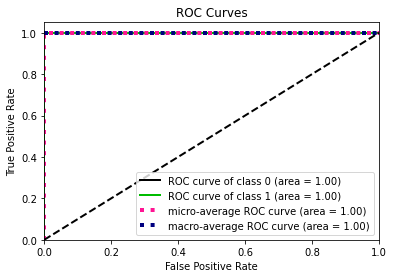

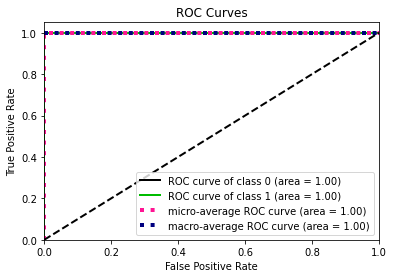

In [80]:
plot_roc(y_true=St['y^'],y_probas=modelo.predict_proba(Xt[best]))
plot_roc(y_true=Sv['y^'],y_probas=modelo.predict_proba(Xv[best]))

## Best1

In [81]:
St1 = Xt1.merge(yt1,on=um,how='inner')
Sv1 = Xv1.merge(yv1,on=um,how='inner')

In [82]:
St1['y^'] = modelo1.predict(Xt1[best1])
Sv1['y^'] = modelo1.predict(Xv1[best1])

St1['proba'] = modelo1.predict_proba(Xt1[best1])[:,1]
Sv1['proba'] = modelo1.predict_proba(Xv1[best1])[:,1]

In [83]:
print(accuracy_score(y_pred=St1['y^'],y_true=St1[vart[0]]))
print(accuracy_score(y_pred=Sv1['y^'],y_true=Sv1[vart[0]]))

0.9895445040458224
0.9893955461293743


In [84]:
print(confusion_matrix(y_pred=St1['y^'],y_true=St1[vart[0]]))
print(confusion_matrix(y_pred=Sv1['y^'],y_true=Sv1[vart[0]]))

[[5307   96]
 [  19 5577]]
[[2365   44]
 [   6 2300]]


In [85]:
print(roc_auc_score(y_true=St1['y^'],y_score=St1['proba']))
print(roc_auc_score(y_true=Sv1['y^'],y_score=Sv1['proba']))

1.0
1.0


<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

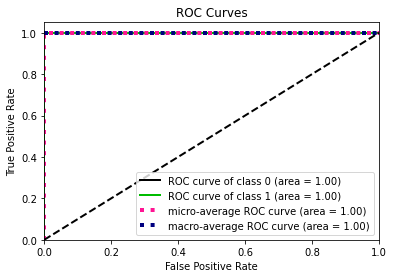

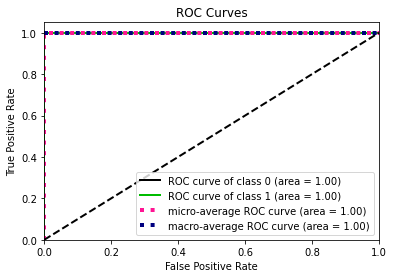

In [86]:
plot_roc(y_true=St1['y^'],y_probas=modelo1.predict_proba(Xt1[best1]))
plot_roc(y_true=Sv1['y^'],y_probas=modelo1.predict_proba(Xv1[best1]))

## $\therefore$ el mejor modelo fue aquel con las variables best

In [87]:
best

['nameOrig', 'oldbalanceDest', 'oldbalanceOrg']